# Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №1 - Метод k-средних, предобработка признаков


# <hr\>
**Общая информация**

**Срок сдачи:** до 7 октября 2017, 06:00   
**Штраф за опоздание:** -2 балла после 06:00 7 октября, -4 балла после 06:00 14 октября, -6 баллов после 06:00 21 октября

При отправлении ДЗ указывайте фамилию в названии файла   


Присылать ДЗ необходимо в виде ссылки на свой github репозиторий в slack @alkhamush
Необходимо в slack создать таск в приватный чат:   
/todo Фамилия Имя *ссылка на гитхаб* @alkhamush   
Пример:   
/todo Ксения Стройкова https://github.com/stroykova/spheremailru/stroykova_hw1.ipynb @alkhamush   

Используйте данный Ipython Notebook при оформлении домашнего задания.
<hr\>

# Первое задание - указать фамилию в имени файла

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,5)

# Пролог: Модуль sklearn
На наших практических занятиях мы будем использовать [sklearn](http://scikit-learn.org/stable/index.html) (scikit-learn) - наиболее популярный модуль для работы с методами машинного обучения и анализа данных.

Этот модуль регулярно обновляется, расширяется и сопровождается примерами использования тех или иных методов. Помимо самих алгоритмов (например k-средних или линейной регрессии) в нем есть множество вспомогательных функций по работе с данными.

# Туториал: Работа с различными типами признаков

Вспомним, какие типы признаков могут встретится при описании объектов исследования и как их представить в доступной для обработки компьютером форме

Типы признаков мы будем рассматривать на примере довольно популярного набора данных [titanic](https://www.kaggle.com/c/titanic/download/train.csv) - информации о выживаемости пассажиров после известной трагедии корабля Titanic.

In [2]:
df_titanic = pd.read_csv('train.csv', sep=',').dropna()
df_titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
10,11,1,3,"Sandstrom, Miss. Marguerite Rut",female,4.0,1,1,PP 9549,16.7000,G6,S
11,12,1,1,"Bonnell, Miss. Elizabeth",female,58.0,0,0,113783,26.5500,C103,S


## Бинарные признаки
Это признаки с двумя возможными значениями
* Пол (мужской, женский)
* Выжил (да, нет)

На вход в алгоритмы обычно подаются в виде значений `{0, 1}` (реже в виде `{-1, 1}`)

In [3]:
# Здесь все нормально
df_titanic.Survived.value_counts()

1    123
0     60
Name: Survived, dtype: int64

In [4]:
# Тут стоит выполнить переобознаение
df_titanic.Sex.value_counts()

male      95
female    88
Name: Sex, dtype: int64

In [5]:
# Например так
df_titanic.Sex = df_titanic.Sex.replace({'male': 0, 'female': 1})
df_titanic.Sex.value_counts()

0    95
1    88
Name: Sex, dtype: int64

## Вещественные признаки

* Возраст
* Сумма, потраченная на билет
* Количество родственников на борту

Как правило остаются в том же виде или выполняется **нормализация** признаков, т.е. переход к одинаковой шкале, например:

* $\tilde{x} = \frac{x - \text{mean}(x)}{\text{std}(x)}$
* $\tilde{x} = \frac{x - \text{min}(x)}{\text{max}(x) - \text{min}(x)}$

## Категориальные признаки

Принимают значения из *неупорядоченного* множества

* Порт погрузки (C = Cherbourg; Q = Queenstown; S = Southampton)
* Точка отправления (St Louis, MO; Montreal, PQ; .. }
* Точка назначения (Chesterville, ON; Roseville, IL; .. }

Обычно такие признаки кодируют с помощью так называемого One Hot Encoding: </br>
для каждой категории создается бинарная маска-столбец, в которой стоит `1` если значение признака равно значению соответствующей категории категории.

Например, для признака "порт погрзки" создается бинарная макска из трех стобцов для каждого из портов: С, Q, S<br/>
Если пассажир заходил на кораблю в порту Southampton, то его признаковое описание будет соответственно: `[0, 0, 1]`

In [6]:
df_titanic.Embarked.head()

1     C
3     S
6     S
10    S
11    S
Name: Embarked, dtype: object

In [7]:
# Сделать в python это можно несколькими способами:

# 1: Через pandas (не очень рекомендуется)
emb = pd.get_dummies(df_titanic.Embarked, prefix='Embarked', prefix_sep='=')
emb.head()

,Embarked=C,Embarked=Q,Embarked=S
1,1,0,0
3,0,0,1
6,0,0,1
10,0,0,1
11,0,0,1


In [8]:
# 2: Функционал sklearn
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(sparse=False)

emb = df_titanic.loc[:, ['Embarked']].replace({'C': 0, 'Q': 1, 'S': 2}).values
emb_enc = encoder.fit_transform(emb)
emb_enc[:5]

array([[ 1.,  0.,  0.],
       [ 0.,  0.,  1.],
       [ 0.,  0.,  1.],
       [ 0.,  0.,  1.],
       [ 0.,  0.,  1.]])

Про другием способы работы с категориальными переменными можно прочитать вот [тут](https://alexanderdyakonov.wordpress.com/2016/08/03/python-%D0%BA%D0%B0%D1%82%D0%B5%D0%B3%D0%BE%D1%80%D0%B8%D0%B0%D0%BB%D1%8C%D0%BD%D1%8B%D0%B5-%D0%BF%D1%80%D0%B8%D0%B7%D0%BD%D0%B0%D0%BA%D0%B8/)

## Порядковый признаки

Принимают значения из *упорядоченного* множества

* Класс каюты (1 > 2 > 3)

В зависимости от метода остаются можно оставить в исходном виде или применить OneHotEncoding.

## Текстовые признаки - Bag of words

Для демонстрации возьмем текст стихотворения Блока:

Ночь, улица, фонарь, аптека,<br/>
Бессмысленный и тусклый свет.<br/>
Живи еще хоть четверть века -<br/>
Все будет так. Исхода нет.<br/>

Умрешь - начнешь опять сначала<br/>
И повторится все, как встарь:<br/>
Ночь, ледяная рябь канала,<br/>
Аптека, улица, фонарь.<br/>

Пусть каждая строчка - это будет условный документ. Переведем эти документы в числовое представление по методу мешка слов (Bag Of Words)

In [9]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

corpus = \
[u'Ночь, улица, фонарь, аптека,',
 u'Бессмысленный и тусклый свет.',
 u'Живи еще хоть четверть века -',
 u'Все будет так. Исхода нет.',
 u'Умрешь - начнешь опять сначала',
 u'И повторится все, как встарь:',
 u'Ночь, ледяная рябь канала,',
 u'Аптека, улица, фонарь.']

In [10]:
vect = CountVectorizer()

bow = vect.fit_transform(corpus)
# print(bow)
bow = bow.toarray()
bow.shape

(8, 27)

Получили матрицу размера $8 \times 27$, так как у нас 8 строчек и выделилось 27 униальных слов. Элемент матрицы показывает сколько раз слово встречалось в соответствующем документе.

In [11]:
bow

array([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
        1, 0, 1, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
        0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 1, 1],
       [0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0,
        0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0,
        0, 1, 0, 0, 0],
       [0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0,
        0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 0, 1, 0, 0]])

In [12]:
# Посмотрим какие слова стоят по столбцам
for i, w in enumerate(vect.get_feature_names()):
    print u'столбец %d: %s' % (i, w)

столбец 0: аптека
столбец 1: бессмысленный
столбец 2: будет
столбец 3: века
столбец 4: все
столбец 5: встарь
столбец 6: еще
столбец 7: живи
столбец 8: исхода
столбец 9: как
столбец 10: канала
столбец 11: ледяная
столбец 12: начнешь
столбец 13: нет
столбец 14: ночь
столбец 15: опять
столбец 16: повторится
столбец 17: рябь
столбец 18: свет
столбец 19: сначала
столбец 20: так
столбец 21: тусклый
столбец 22: улица
столбец 23: умрешь
столбец 24: фонарь
столбец 25: хоть
столбец 26: четверть


# Туториал: Имплементация собственного метода

Для решения задач вида "имплементируйте метод X" крайне желательно (но необязательно) реализовывать методы с помощью интерфейса sklearn. Ниже вы увидите пример очень простого **классификатора**. Используйте эти наработи для выполнения задания.

Загрузите [датасет](https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv) с информацией о характеристиках вина и его качестве. (В метод `pd.read_csv()` можно подать веб-ссылку на данные и пандас их скачает и преобразует в `DataFrame`).

In [13]:
df_wine = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv', sep=';')

In [14]:
df_wine.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


Наша задача состоит в предсказании целевого признака `quality` по остальным признакам. `quality` - это вещественная переменная (оценка качества от 0 до 10). Упростим себе задачу - создадим новый столбец `quality_cat` по следующим правилам:

* `quality_cat = 1` если `quality > 5` 
* `quality_cat = 0` - иначе 

Таким образом, `quality_cat` характерует "плохое" и "хорошее" вино.

In [15]:
def prepocess_wine(df):
    df.loc[:, 'quality_cat'] = (df.loc[:, 'quality'] > 5).astype(int)
    df = df.drop('quality', axis=1)
    
    return df

In [16]:
df_wine = df_wine.pipe(prepocess_wine)
df_wine.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality_cat
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,0
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,0
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,1
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,0


Нарисуем распределение хорошего и плохого вина по признаку `alcohol`.

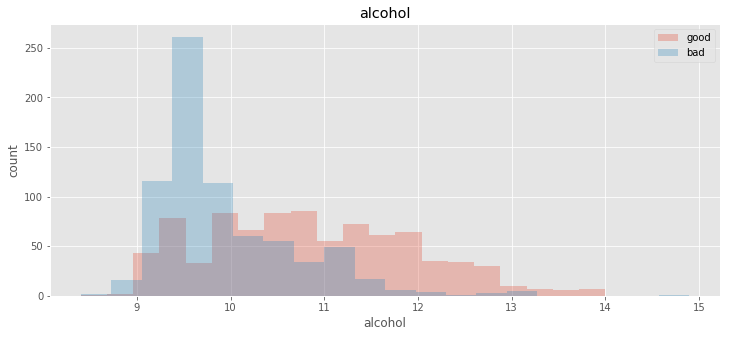

In [17]:
_, ax = plt.subplots(1,1)
df_wine.query('quality_cat == 1').hist('alcohol', alpha=0.3, bins=20, label='good', ax=ax)
df_wine.query('quality_cat == 0').hist('alcohol', alpha=0.3, bins=20, label='bad', ax=ax)
ax.set_xlabel('alcohol')
ax.set_ylabel('count')
plt.legend()

Визуально кажется, что можно найти некоторое пороговое значение признака `alcohol` $\theta$, чтобы хорошо дискриминировать между плохими и хорошим вином:
* Если `alcohol >` $\theta$ - то предсказываем, что вино хорошее
* Если `alcohol <=` $\theta$ - то предсказываем, что вино плохое

Обучаеть классификатор будем очень просто: перебирать значения признака alchol и считать **ошибку** классификации. То значение, где ошибка минимальна и будет оптимальным.

Разделим целевой признак от остальных признаков

In [18]:
X, y = df_wine.iloc[:, :-1].values, df_wine.iloc[:, -1].values

Далее вы увидете пример реализации этого простого классификатора.

In [19]:
from sklearn.base import BaseEstimator, ClassifierMixin

class SimpleClassifier(BaseEstimator, ClassifierMixin): 
    
    def __init__(self):
        """
        Инициализация метода
        """
        
        self.threshold = 0

    def fit(self, X, y=None):
        """
        Выполняет процедуру обучения классификатора. В данном случае - перебор занчения признака alcohol.
        Договоримся, что признак alcohol будет в последнем столбце матрицы X
        """
        
        alcohol = X[:,-1]
        n = float(y.shape[0])
        
        # Задаем пространство поиска
        alco_range = np.arange(alcohol.min(), alcohol.max(), 0.1)
        
        min_error_rate = 1
                
        #  Начинаем поиск
        for theta in alco_range:
            prediction = alcohol > theta
            
            error_rate = sum(prediction != y)/n
            
            if error_rate < min_error_rate:
                min_error_rate = error_rate
                self.threshold = theta  
        
        return self

    def predict(self, X, y=None):
        """
        Процедура предсказания класса по обученному порогу
        """
        
        return (X[:,-1] > self.threshold).astype(int)

Обучаем модель

In [20]:
model = SimpleClassifier()
model.fit(X, y)

print 'Оптимальный порог: %f' % model.threshold

Оптимальный порог: 10.000000


Получаем предсказание модели (на обучающей выборке)

In [21]:
y_hat = model.predict(X)

Оценим долю ошибок на обучающей выборке

In [22]:
error_rate = sum(y_hat != y)/float(y.shape[0])
print 'Доля ошибок на обучающей выборке: %f' % error_rate

Доля ошибок на обучающей выборке: 0.295184


## Проверка метода на контрольной выборке

Мы обучили наш метод на данных о красном виде. 

Посмотрим, выполняется ли так же хорошо закономерность между качеством и уровнем алкоголя в белом вине.

In [23]:
df_wine_test = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv',
                           sep=';')

df_wine_test = df_wine_test.pipe(prepocess_wine)
df_wine_test.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality_cat
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,1
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,1
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,1
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,1
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,1


In [24]:
X_test, y_test = df_wine_test.iloc[:, :-1].values, df_wine_test.iloc[:, -1].values
y_hat = model.predict(X_test)

In [25]:
error_rate = sum(y_hat != y_test)/float(y_test.shape[0])
print 'Доля ошибок на контрольной выборке: %f' % error_rate

Доля ошибок на контрольной выборке: 0.312577


Получилось неплохо и это лишь наивный алгоритм на одном признаке! Ну а выводы делайте сами =)

# Имплементация K-means

Пользуясь наработками выше, имплементируйте метод k-means.  
При инициализации необходимо задавать количество кластеров, функцию расстояния между кластерами (для оригинального k-means - евклидово расстояние) и начальное состояние генератора случайных чисел.

После обучения, среди атрибутов класса `Kmeans` должны появится
* Метки кластеров для объектов
* Координаты центройдов кластеров

k-means - это алгоритм **кластеризации**, а не классификации, а посему метод `.predict()` в нем фактически не нужен, но он может возвращать метки ближайшего кластера для объектов.

###### Задание 1 (2 баллов)
Имплементируйте метод k-means

Теория для выполнения задания 2 и 3 остаётся на самостоятельное изучение. Теории немного и она совсем простая.

###### Задание 2 (2 балла)
Имплементируйте класс MiniBatchKMeans, который является классом наследником Kmeans.

###### Задание 3 (2 балла)
Превратите k-means в k-means++. Для этого нужно реализовать метод в классе Kmeans, который будет инициализировать более "хорошие" значения центроидов. Чтобы использовался метод k-means++, в параметр init необходимо передать строковое значение 'k-means' (по умолчанию 'random').

###### Задание 4 (2 балла)
В пункте "Проверка корректности метода" нужно нарисовать графики, которые показывают зависимость времени выполнения алгоритма от количества сэмплов. Графики должны быть  нарисованы для различных комбинаций реализаций алгоритма (k-means, k-means++, k-means с MiniBatchKMeans, k-means++ с MiniBatchKMeans). Для этого рекомендуется использовать инструмент %timeit. График достаточно построить на 5-10 точках.

###### Задание 5 (2 балла)
В пункте "Применение K-means на реальных данных" нужно сравнить различные реализации k-means (k-means, k-means++, k-means с MiniBatchKMeans, k-means++ с MiniBatchKMeans). После чего написать вывод, в котором должно быть объяснение того, почему один алгоритм оказался лучше остальных или почему не было выявлено лучшего алгоритма.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator
from sklearn.base import ClusterMixin
from scipy.spatial.distance import pdist, euclidean, cdist

%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (6,6)

class Kmeans(BaseEstimator, ClusterMixin): 
    
    def __init__(self, k=2, metric='euclidean', max_iter=1000, random_state=None, init='random'):
        """
        Инициализация метода
        :k - количество кластеров
        :metric - функция расстояния между объектами
        :max_iter - максимальное количество итераций
        :random_state - seed для инициализации генератора случайных чисел
        """
        
        self.k = k
        self.random_state = random_state
        self.metric = metric
        self.max_iter = max_iter
        self.init = init

    def fit(self, X, y=None):
        """
        Процедура обучения k-means
        """
        
        # Инициализация генератора случайных чисел
        np.random.seed(self.random_state)
        
        # Массив с метками кластеров для каждого объекта из X
        self.labels = np.empty(X.shape[0], dtype=np.intc)
        
        # Массив с центройдами кластеров
        self.centroids = np.empty((self.k, X.shape[1]))
        
        self.set_centroids(X)

        self.make_iterations(X)
                
        return self

    def predict(self, X, y=None):
        """
        Процедура предсказания кластера
        
        Возвращает метку ближайшего кластера для каждого объекта
        """
        
    def set_centroids(self, X):
        if self.init == 'k-means':
            self.pp_centroids(X)
        elif self.init == 'random':
            self.centroids = self.pick_random_elems(self.k, X)
        else:
            raise ValueError('unknown value for init = `{}`'.format(self.init))

    def pp_centroids(self, X):
        len_X = X.shape[0]
        dist_sq = np.empty(len_X)
        self.centroids[0] = self.pick_random_elems(1, X)[0]
        count_chosen = 1
        while count_chosen < self.k:
            probs = cdist(X, self.centroids[:count_chosen], metric=self.metric).min(axis=1)**2
            probs = probs / probs.sum()
            new_c_index = np.random.choice(len_X, 1, p=probs)
#             for j, x in enumerate(X):
# #                 min_dist = euclidean((self.centroids[0], x)
                
#                 min_dist = pdist((self.centroids[0], x), metric=self.metric)[0]
#                 for i in range(1, count_chosen):
#                     dist = pdist((self.centroids[i], x), metric=self.metric)[0]
#                     if dist < min_dist:
#                         min_dist = dist
#                 dist_sq[j] = min_dist * min_dist
                
#             dist_sq_sum = np.sum(dist_sq)
#             new_c_index = np.random.choice(len_X, 1,
#                 p=np.apply_along_axis(lambda x: x / dist_sq_sum, 0, dist_sq)
#             )
            self.centroids[count_chosen] = X[new_c_index]    
            count_chosen += 1
                    
                    
    def pick_random_elems(self, count, elems_array):
        return elems_array[np.random.choice(elems_array.shape[0], count)]
#         random_indicies = np.random.choice(elems_array.shape[0], count)
#         return np.apply_along_axis(lambda i: elems_array[i], 0, random_indicies)

    def make_iterations(self, X):
        for i in xrange(self.max_iter):
            self.iterate(X)
    
    def iterate(self, X):
#         def timed_get_nearest_cluster(elem):
#             res = profile_print(self.get_nearest_cluster, elem)
#             return res

#         get_labels = np.vectorize(self.get_nearest_cluster, '')
#         self.labels = get_labels(X)

        self.labels = cdist(X, self.centroids, metric=self.metric).argmin(axis=1)
#         dists = np.apply_along_axis(self.get_nearest_cluster, 1, X)
        
#         print(dists)

#         self.labels = np.apply_along_axis(self.get_nearest_cluster, 1, X)
        
        to_bool_mask = np.vectorize(lambda cluster: cluster == class_id)

        for class_id in xrange(self.k):
            mask = to_bool_mask(self.labels)
            self.centroids[class_id] = np.mean(X[mask], axis=0) 
class MiniBatchKMeans(Kmeans):
    def __init__(self, *arg_pos, **arg_dict):
        if 'b' in arg_dict:
            self.b = arg_dict['b']
        else:
            self.b = None
            
        arg_dict_super = {key : arg_dict[key] for key in arg_dict if key != 'b'}
        Kmeans.__init__(self, *arg_pos, **arg_dict_super)
        
    def make_iterations(self, X):
        b = (X.shape[0] // 5) if self.b is None else self.b
        v = np.zeros(self.k, dtype=int)
        d = np.empty(b, dtype=int)
        
        for i in xrange(self.max_iter):
            M = self.pick_random_elems(b, X)
            d = cdist(M, self.centroids, metric=self.metric).argmin(axis=1)
            
#             for i, x in enumerate(M):
#                 c_number = d[i]
#                 v[c_number] += 1
#                 eta = 1.0 / v[c_number]
#                 self.centroids[c_number] = self.centroids[c_number] * (1 - eta) + eta * x
            for class_id in xrange(self.k):
                to_bool_mask = np.vectorize(lambda cluster: cluster == class_id)
                mask = to_bool_mask(d)
                M_c = M[mask]
                old_v = v[class_id]
                new_v = old_v + M_c.shape[0]
                values = np.append([old_v * self.centroids[class_id]], M_c, axis=0)
                self.centroids[class_id] = values.sum(axis=0) / new_v
#                 old_sum = self.centroids[class_id] * old_v
#                 new_sum = M_c.sum(axis=0)
#                 print(new_sum.shape)
#                 self.centroids[class_id] = (old_sum + new_sum) / (old_v + M_c.shape[0])
# 
                v[class_id] = new_v
#                 print(class_id, self.centroids[class_id])
#                 print(old_sum)
#                 print(new_sum)
#                 print('-----')
            
        self.labels = cdist(X, self.centroids, metric=self.metric).argmin(axis=1)
        

In [2]:
# timetesting
count_centers = 5
time_X, time_y = make_blobs(n_samples=1000, n_features=2, centers=count_centers, cluster_std=1, 
           center_box=(-10.0, 10.0), shuffle=False, random_state=1234)

time_means = MiniBatchKMeans(k=count_centers, random_state=1000, max_iter=40)
% timeit time_means.fit(time_X)
# time_means.fit(time_X)
# profile_print(time_means.fit, time_X)
plt.scatter(time_X[:,0], time_X[:, 1], c=time_means.labels)

NameError: name 'make_blobs' is not defined

### Проверка корректности метода

Перед тем как применять алгоритм на реальных данных, нужно испытать его на простых "игрушечных" данных.

Если алгоритм реализован правильно, то метод должен идеально разбивать на 3 кластера данные ниже. Проверьте это.

ВНИМАНИЕ! Проверка должна быть осуществлена на всех реализациях, иначе реализация не будет зачтена!

In [3]:
from sklearn.datasets import make_blobs

In [4]:
X, y = make_blobs(n_samples=100, n_features=2, centers=3, cluster_std=1, 
           center_box=(-10.0, 10.0), shuffle=False, random_state=12324)

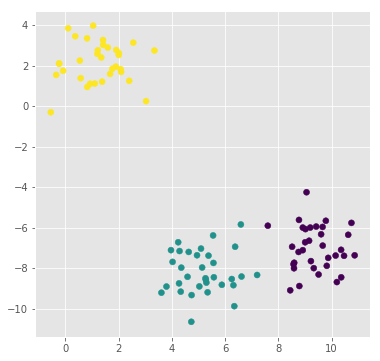

In [5]:
plt.scatter(X[:,0], X[:, 1], c=y)

Проверьте Вашу имплементацию на простых данных (без этого пункта задание не считается выполненным).   
КОММЕНТАРИИ НЕ СТИРАТЬ!

In [6]:
random_state_kmeans = 1024
benchmark_data = {key : [] for key in ['name', 'dots_count', 'taken_time']}
test_Xs = []
cluster_count = 4
sample_counts = [100, 500, 1000, 2500, 5000]
for sample_count in sample_counts:
    test_X, _ = make_blobs(n_samples=sample_count, n_features=3, centers=cluster_count, cluster_std=1, 
                   center_box=(-10.0, 10.0), shuffle=False, random_state=1234)
    test_Xs.append(test_X)

100 loops, best of 3: 5.3 ms per loop
100 loops, best of 3: 9.96 ms per loop
100 loops, best of 3: 15.8 ms per loop
10 loops, best of 3: 33.2 ms per loop
10 loops, best of 3: 62.1 ms per loop


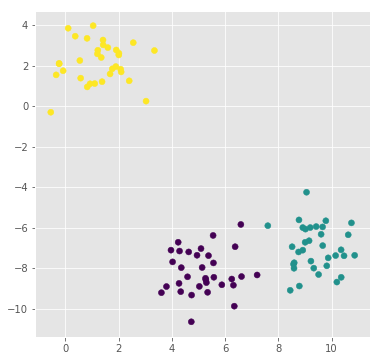

In [7]:
## Работоспособность KMeans
for i, test_X in enumerate(test_Xs):
    test_kmeans = Kmeans(k=cluster_count, random_state=random_state_kmeans, max_iter=10)
    res = %timeit -o test_kmeans.fit(test_X)
    benchmark_data['name'].append('kmeans')
    benchmark_data['dots_count'].append(sample_counts[i])
    benchmark_data['taken_time'].append(res.worst)
    
test_kmeans = Kmeans(k=3, random_state=random_state_kmeans, max_iter=3)
test_kmeans.fit(X)
plt.scatter(X[:,0], X[:, 1], c=test_kmeans.labels)


100 loops, best of 3: 5.79 ms per loop
100 loops, best of 3: 10.9 ms per loop
100 loops, best of 3: 16.6 ms per loop
10 loops, best of 3: 33.7 ms per loop
10 loops, best of 3: 62.5 ms per loop


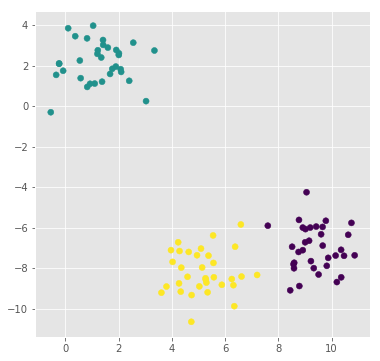

In [8]:
## Работоспособность KMeans++
for i, test_X in enumerate(test_Xs):
    test_pp_kmeans = Kmeans(k=cluster_count, random_state=random_state_kmeans, max_iter=10, init='k-means')
    res = %timeit -o test_pp_kmeans.fit(test_X)
    benchmark_data['name'].append('kmeans++')
    benchmark_data['dots_count'].append(sample_counts[i])
    benchmark_data['taken_time'].append(res.worst)
    
test_pp_kmeans = Kmeans(k=3, random_state=random_state_kmeans, max_iter=3, init='k-means')
test_pp_kmeans.fit(X)
plt.scatter(X[:,0], X[:, 1], c=test_pp_kmeans.labels)

100 loops, best of 3: 5.9 ms per loop
100 loops, best of 3: 6.87 ms per loop
100 loops, best of 3: 8.24 ms per loop
100 loops, best of 3: 12.3 ms per loop
10 loops, best of 3: 18.8 ms per loop


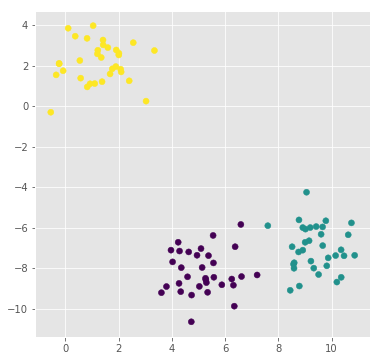

In [9]:
## Работоспособность KMeans с MiniBatchKMeans
for i, test_X in enumerate(test_Xs):
    test_b_kmeans = MiniBatchKMeans(k=cluster_count, random_state=random_state_kmeans, max_iter=10)
    res = %timeit -o test_b_kmeans.fit(test_X)
    benchmark_data['name'].append('mb_kmeans')
    benchmark_data['dots_count'].append(sample_counts[i])
    benchmark_data['taken_time'].append(res.worst)
    
test_b_kmeans = MiniBatchKMeans(k=3, random_state=random_state_kmeans, max_iter=10)
test_b_kmeans.fit(X)
plt.scatter(X[:,0], X[:, 1], c=test_b_kmeans.labels)


100 loops, best of 3: 6.48 ms per loop
100 loops, best of 3: 7.56 ms per loop
100 loops, best of 3: 9.27 ms per loop
100 loops, best of 3: 13.6 ms per loop
10 loops, best of 3: 20.3 ms per loop


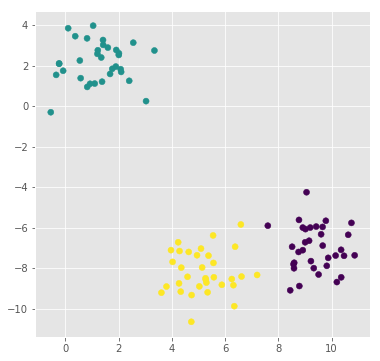

In [10]:
## Работоспособность KMeans++ с MiniBatchKMeans
for i, test_X in enumerate(test_Xs):
    test_all_kmeans = MiniBatchKMeans(k=cluster_count, random_state=random_state_kmeans, max_iter=10, init='k-means')
    res = %timeit -o test_all_kmeans.fit(test_X)
    benchmark_data['name'].append('mb_kmeans++')
    benchmark_data['dots_count'].append(sample_counts[i])
    benchmark_data['taken_time'].append(res.worst)
    
test_all_kmeans = MiniBatchKMeans(k=3, random_state=random_state_kmeans, max_iter=10, init='k-means')
test_all_kmeans.fit(X)
plt.scatter(X[:,0], X[:, 1], c=test_all_kmeans.labels)

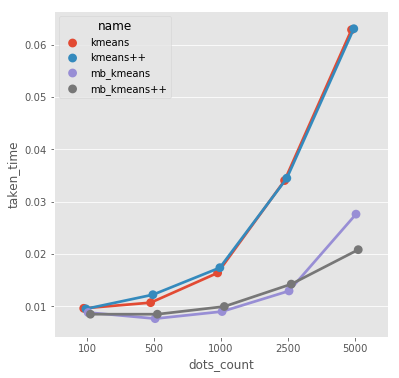

In [11]:
## Время выполнения алгоритма KMeans
## Время выполнения алгоритма KMeans++
## Время выполнения алгоритма KMeans с MiniBatchKMeans
## Время выполнения алгоритма  KMeans++ с MiniBatchKMeans
df_benchmark = pd.DataFrame.from_dict(benchmark_data)
import seaborn as sns
sns.pointplot(x="dots_count", y="taken_time", hue="name", data=df_benchmark, dodge=True)

# Применение K-means на реальных данных

Загрузите [данные](https://github.com/brenden17/sklearnlab/blob/master/facebook/snsdata.csv) в которых содержится описание интересов профилей учеников старшей школы США.  (без этого пункта задание не считается выполненным).   
ВНИМАНИЕ! Проверка должна быть осуществлена на всех реализациях, иначе реализация не будет зачтена!

Данные устроены так: 
* Год выпуска
* Пол
* Возраст
* Количество друзей
* 36 ключевых слов, которые встречаются в профилe facebook (интересы, сообщества, встречи)

* Удалите все признаки кроме 36 ключевых слов.
* Нормализуйте данные - из каждого столбца вычтите его среднее значение и поделите на стандартное отклонение.
* Используйте метод k-means чтобы выделить 9 кластеров
* Попробуйте проинтерпретировать каждый кластер проанализировав полученные центройды (Некоторые кластеры могут быть очень большие и очень маленькие - плохо интерпретируются)   
КОММЕНТАРИИ НЕ СТИРАТЬ!

In [12]:
df_sns = pd.read_csv('snsdata.csv', sep=',')
real_X = df_sns.iloc[:, 4:].as_matrix().astype(float)

for i in xrange(real_X.shape[1]):
    col = real_X[:,i]
    col_std = np.std(col)
    col_mean = np.mean(col)
    real_X[:,i] = (col - col_mean) / col_std

In [16]:
## KMeans
kmeans = Kmeans(k=9, random_state=10224, max_iter=20, metric='euclidean')
kmeans.fit(real_X)
# 1 loop, best of 3: 1.95 s per loop

represent = df_sns.iloc[:, :4]
represent['cluster'] = kmeans.labels
represent.groupby('cluster').agg({'cluster':{'size': len}})

1 loop, best of 3: 1.95 s per loop


,cluster
,size
cluster,
0,2162
1,621
2,753
3,905
4,1790
5,828
6,3476
7,501


In [17]:
## KMeans++
pp_kmeans = Kmeans(k=9, random_state=10224, max_iter=20, metric='cosine', init='k-means')
pp_kmeans.fit(real_X)
# 1 loop, best of 3: 2.29 s per loop

represent = df_sns.iloc[:, :4]
represent['cluster'] = pp_kmeans.labels
represent.groupby('cluster').agg({'cluster':{'size': len}})

1 loop, best of 3: 2.29 s per loop


,cluster
,size
cluster,
0,2517
1,2656
2,11648
3,1617
4,3044
5,1868
6,1538
7,2974


In [20]:
## KMeans с MiniBatchKMeans
b_kmeans = MiniBatchKMeans(k=9, random_state=10224, max_iter=50, metric='euclidean')
b_kmeans.fit(real_X)
# 1 loop, best of 3: 1.16 s per loop

represent = df_sns.iloc[:, :4]
represent['cluster'] = b_kmeans.labels
represent.groupby('cluster').agg({'cluster':{'size': len}})

1 loop, best of 3: 1.16 s per loop


,cluster
,size
cluster,
0,1713
1,366
2,822
3,443
4,1587
5,861
6,5961
7,487


In [22]:
## KMeans++ с MiniBatchKMeans
all_kmeans = MiniBatchKMeans(k=9, random_state=10224, max_iter=50, metric='cosine', init='k-means')
all_kmeans.fit(real_X)
# 1 loop, best of 3: 1.65 s per loop

represent = df_sns.iloc[:, :4]
represent['cluster'] = all_kmeans.labels
represent.groupby('cluster').agg({'cluster':{'size': len}})

1 loop, best of 3: 1.65 s per loop


,cluster
,size
cluster,
0,2434
1,2741
2,11558
3,1921
4,2751
5,2055
6,1556
7,2818


In [88]:
# understanding clusters
u_kmeans = Kmeans(k=9, random_state=10224, max_iter=10, metric='cosine')
u_kmeans.fit(real_X)

represent = df_sns.iloc[:, :4]
represent['cluster'] = u_kmeans.labels

interests = df_sns.columns[4:-1]
aggs = {key : np.sum for key in interests}
aggs['cluster'] = {'size': len}

represent = df_sns.iloc[:, :]
represent['cluster'] = kmeans.labels
res = represent.groupby('cluster').agg(aggs)

for interest in interests:
    res[interest] = res[interest]['sum'] / np.sum(res[interest]['sum'])
    
from IPython import display
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display.display(res)

,cute,drunk,dance,sex,hair,cluster,church,blonde,kissed,dress,marching,basketball,god,tennis,sports,hot,music,abercrombie,soccer,shopping,drugs,football,cheerleading,band,death,baseball,softball,sexy,jesus,bible,die,volleyball,mall,rock,hollister,clothes,swimming
,sum,sum,sum,sum,sum,size,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum
cluster,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.432790,0.057219,0.197805,0.083095,0.116510,2768,0.073606,0.108827,0.058786,0.059477,0.004926,0.070200,0.081883,0.051908,0.050250,0.506056,0.090806,0.015635,0.084094,0.113975,0.034749,0.070022,0.201938,0.045171,0.091042,0.049873,0.050455,0.389046,0.044021,0.023438,0.082564,0.089660,0.224323,0.088630,0.030057,0.131313,0.064236
1,0.113669,0.628268,0.148961,0.545686,0.396860,2535,0.078308,0.337601,0.675388,0.136377,0.029557,0.109601,0.127874,0.089695,0.167183,0.088468,0.163994,0.085993,0.100853,0.087535,0.726420,0.092879,0.097530,0.113485,0.325941,0.086086,0.066998,0.158404,0.069899,0.070312,0.400688,0.079879,0.152182,0.219315,0.064408,0.300337,0.094246
2,0.033863,0.025009,0.047824,0.029608,0.036128,1391,0.037743,0.027628,0.025517,0.032743,0.920361,0.029052,0.044344,0.037405,0.026911,0.026330,0.075491,0.007818,0.036062,0.032956,0.022063,0.039371,0.020944,0.538718,0.051940,0.019377,0.023780,0.035175,0.040452,0.031250,0.041282,0.024220,0.032120,0.065342,0.006202,0.035241,0.040923
3,0.056473,0.039788,0.079733,0.034702,0.058216,2327,0.508798,0.065027,0.034561,0.038750,0.012315,0.076060,0.341214,0.436641,0.067159,0.047920,0.087599,0.011726,0.161155,0.074504,0.041919,0.056018,0.077524,0.061193,0.107966,0.046061,0.044458,0.046034,0.565437,0.781250,0.085280,0.093153,0.070587,0.081781,0.014790,0.072503,0.055060
4,0.062461,0.037893,0.084516,0.063992,0.065867,2941,0.064338,0.127022,0.034561,0.027035,0.011494,0.408354,0.076510,0.089313,0.382234,0.056082,0.093833,0.011075,0.212629,0.061756,0.022614,0.520544,0.141919,0.044504,0.062737,0.617535,0.085401,0.069877,0.058894,0.021875,0.056491,0.234746,0.076674,0.114521,0.019561,0.060157,0.060516
5,0.078877,0.054187,0.076989,0.047119,0.088586,1589,0.043788,0.091644,0.050388,0.062481,0.007389,0.056858,0.046063,0.070611,0.056918,0.090311,0.055794,0.837785,0.069430,0.117469,0.045780,0.063945,0.160050,0.028037,0.058068,0.049873,0.049628,0.059490,0.036883,0.021875,0.052870,0.080112,0.113716,0.049726,0.822519,0.112458,0.071429
6,0.069895,0.037893,0.105057,0.046004,0.074623,2831,0.061786,0.077156,0.034884,0.030940,0.002463,0.063591,0.072355,0.075191,0.065015,0.060558,0.182471,0.011075,0.121203,0.337866,0.018753,0.049016,0.108471,0.047953,0.075285,0.036849,0.031224,0.052408,0.053540,0.017188,0.059207,0.108291,0.127963,0.174658,0.019561,0.146577,0.502480
7,0.070824,0.035620,0.111250,0.040115,0.070364,2019,0.062458,0.057951,0.035207,0.602583,0.011494,0.098005,0.058170,0.050763,0.077161,0.053976,0.064152,0.018893,0.060602,0.090463,0.028682,0.053640,0.079712,0.044281,0.067406,0.048602,0.600496,0.049339,0.039262,0.023438,0.058483,0.175361,0.084316,0.056575,0.022901,0.070483,0.047619


## Вывод

### Kmeans
Модификации имеют свои преимущества и недостатки.

MiniBatch дает ощутимый выигрыш по времени, однако точность несколько падает.

KMeans++ позволяет защититься от ситуации, когда два центроида оказываются случайно выбраны слишком близко друг к другу. Тем не менее, при большом числе точек время кластеризации ощутимо растет.

Таким образом, ни одну из модификаций алгоритма нельзя считать лучшей. Выбор должен определяться обстоятельствами.

### Интерпретация реальных данных

Исследовав результаты кластеризации обычным Kmeans с косинусной метрикой, я обнаружил следующие кластеры

1. Интересующиеся танцами и магазинами, которым нравится все симпатичное и сексуальное
1. Маргинальные любители наркотиков, секса и выпить, которые также больше других ценят поцелуи, волосы (!), блондинок, рок и смерть
1. Конспирлогическая секта -- рассказали о своих интересах гораздо меньше других
1. Любители церкви, Библии и Иисуса
4. Фанаты игр с мячом
5. Знают толк в шоппинге, разбираются в одежде, предпочитают бренд "Hollister" и "Abercrombie". У них также больше других встречается слово "hot" (?вероятно, перед "sales")
6. Плавцы
7. Софтболисты, которые также ценят одежду
8. Самая большая группа. Из примечательного: в этом большом коллективе в ноль игнорируют "Hollister" и "Abercrombie", а также... походы (marching). В отличие от алкоголиков не маргинальны, хотя спектр интересов очень схож
